In [1]:
%matplotlib widget
import numpy as np
from pygdsm import GlobalSkyModel
from pygdsm import GSMObserver
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
from astropy import units as u
from numpy.fft import fft,fftshift,ifft,ifftshift

from datetime import datetime,timedelta

from astropy.coordinates import SkyCoord, UnitSphericalRepresentation, EarthLocation, AltAz
from astropy.time import Time
from astropy import constants as const
from scipy import io

import h5py
from os import listdir
from os.path import isfile,join
from time import sleep
import csv

import numpy.ma as ma
from tqdm import tqdm  


from astropy.utils.iers import conf
conf.auto_max_age = None

In [2]:
lat = '52.9145'
long = '6.6031'
latlonel=(lat,long,0)

lbanr=[94]#[16,33]#,34,36,72,77,82,83,94]
#ant_pos = np.array([[-305, 305], [0, 305], [305, 305], [-305, 0], [0,0], [305, 0], [-305,-305], [0, -305], [305,-305]])*u.cm
ant_pos = np.array([[-305, 305], [0, 305]])*u.cm


In [3]:
time_step = 15 #minutes
time_interval = 60*24 #minutes
datestr="2022-11-25-11-50-00"
date_time = datetime.strptime(datestr,"%Y-%m-%d-%H-%M-%S")

freqMHz=40
freq=int(freqMHz)*u.MHz
#num_pix = 51 # number of pixels for the model

In [4]:
date_list=[date_time+timedelta(minutes=t) for t in range(0,time_interval,time_step)]

In [5]:
#from skycal import get_lm
#l,m=get_lm(plot=True)

In [6]:
from skycal import LBArad
LBAs=LBArad('antenna/')
beam_pattern,z1,az1=LBAs.getbeam(freqMHz,lbanr)




KeyboardInterrupt: 

In [ ]:
from skycal import get_coord
az_rad,z_rad=get_coord(plot=False)
az_deg=az_rad/np.pi*180
z_deg=z_rad/np.pi*180


In [ ]:

#from skycal import interpolateN
#bp0=interpolateN(beam_pattern[:,0],z1,az1,z_deg,az_deg)
#bp1=interpolateN(beam_pattern[:,1],z1,az1,z_deg,az_deg)
from skycal import interpolate
bp0=interpolate(beam_pattern[0,0],z1,az1,z_deg,az_deg)
bp1=interpolate(beam_pattern[0,1],z1,az1,z_deg,az_deg)


In [ ]:
beam_sky=[bp0,bp1]
#hp.orthview(beam_sky[0][0],title='sky beam X0',half_sky=True)
#hp.orthview(beam_sky[1][0],title='sky beam T0',half_sky=True)
hp.orthview(beam_sky[0],title='sky beam X0',half_sky=True)
hp.orthview(beam_sky[1],title='sky beam T0',half_sky=True)

In [ ]:
from skycal import CalcPower
#pwr=CalcPowerN(freq,date_list,beam_sky)
pwr=CalcPower(freq,latlonel,date_list,beam_sky)

In [ ]:
plt.figure()
plt.plot(10*np.log10(pwr[0].T));
plt.plot(10*np.log10(pwr[1].T));
np.save("Sky%s_%i"%(datestr,freqMHz),pwr)
plt.show()

In [ ]:
from skycal import compute_uv_coordinates
uv = compute_uv_coordinates(ant_pos)
print(uv[0,1])
# plot one of them
plt.figure()
plt.imshow(-np.sqrt(uv[:,:,0]**2+uv[:,:,1]**2))
plt.title('-uv')
plt.colorbar();
plt.show()

In [ ]:
from skycal import calculate_visibility
vis=calculate_visibility(date_list,latlonel,freq,uv,beam_sky)

In [ ]:
print(vis.shape)
minutes=np.arange(0,time_interval,time_step)
plt.figure()
#plt.plot(np.abs(vis[:,1,0,0]));
plt.plot(minutes/60,np.unwrap(np.angle(vis[:,1,0,0]))/np.pi*180);
plt.plot(minutes/60,np.unwrap(np.angle(vis[:,1,0,1]))/np.pi*180);
plt.xlabel("Time (hours)")
plt.ylabel("Vis phase (deg)")
plt.show()

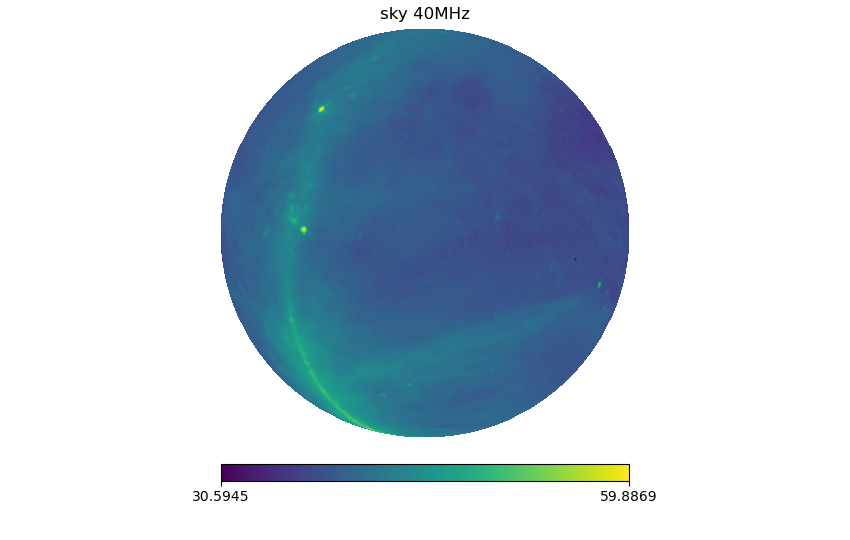

In [7]:
def plotsky(freq,latlonel,date):
    (latitude, longitude, elevation) = latlonel
    ov = GSMObserver()
    ov.lon = longitude
    ov.lat = latitude
    ov.elev = elevation
    ov.date = date
    ov.generate(freq.value,obstime=Time(date)) 
    hp.orthview(10*np.log10(ov.observed_sky),title='sky 40MHz',half_sky=True)
plotsky(freq,latlonel,date_list[0])